***
# Function Approximation in Tensorflow

Function approximation is a technique for **learning** a function $y$ by providing an approximation for the function, $\hat{y}$. A **differentiable function approximator** is a function whose output is a differentiable function of its inputs. There are many differentiable function approximators. You have have heard of linear regressions and logistic regressions. We can abstractly define a function approximator as a set of parameters $\theta$. For example, in a simple quadratic regression of the form
$$
\hat{y} = a x^2 + b x + c
$$
we would have $\theta = \left[ a, b, c \right]$.

***
### Gradient Descent and Loss Functions
When a function approximator is differentiable, we have an additional tool at our disposal: **gradient descent**. Gradient descent is a tool for optimizing any differentiable function. The **gradient** of a function $f$ with respect to some parameters $\theta$ is denoted $\nabla_\theta f$, and is a vector of partial derivatives of $f$ with respect to each variable in $\theta$. For example, $\nabla_\theta \hat{y}$ would be
$$
\nabla_\theta \hat{y} = 
\begin{bmatrix}
x^2 \\
x \\
1
\end{bmatrix}
$$

Imagine some dataset $(X, Y)$ that we are interested in modelling, and we have a suspicion that the relationship between $X$ and $Y$ is quadratic. Then we can use a function like the one described above ($ax^2 + bx + c$) to try to model the dataset.

Given a data point $(x, y)$, we want the difference between our functions output $\hat{y}$ and the true value $y$ to be small. We use the *squared-error* to measure this difference: $\left(y - \hat{y} \right)^2$. If our function approximator $\theta$ *minimizes* the average squared error over all data points, then we say our function successfully models the data.

We define a **loss function** with respect to the model parameters $\theta$ that we want to minimize. In accordance with our description above, we get:
$$
L(\theta) = \frac{1}{N} \sum_{(x, y) \in X \times Y} \left(\hat{y} - y \right)^2
$$
where $N$ is the size of the dataset and $\hat{y} = ax^2 + bx + c $.

We can iteratively modify our paramaters $\theta$ so as to minimize this loss function. If we take the gradient of the loss function with respect to $\theta$ and we subtract that from $\theta$, then we get new values for $\theta$ such that the value $L(\theta)$ is smaller. This gives us **gradient descent**:
$$
\theta \gets \theta + \alpha \nabla_\theta L(\theta)
$$
where $\alpha$ is a factor called the **learning rate** that determines how much we change the network parameters with each application of gradient descent. We perform gradient descent for a given number of **epochs** until we are satisfied that our function does a good approximation.

In this case, we can easily analytically compute this:
$$
\nabla_\theta L(\theta) = \frac{1}{N} \sum_{(x, y) \in (X, Y)} 2(\hat{y} - y) \nabla_{\theta} \hat{y}
$$

where $\nabla_\theta \hat{y}$ is as descibed above.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import gym
import tensorflow as tf
sns.set()

In [2]:
def plot(X, Y, Y_hat):
    data = pd.DataFrame({"X":X, "Y":Y, "Y_hat":Y_hat})
    sns.scatterplot(x="X", y="Y", data=data)
    sns.lineplot(x="X", y="Y_hat", data=data)

In [3]:
N = 50
a, b, c = 2, -1, 4
X = np.linspace(-1, 1, N)
Y = a*X**2 + b*X + c + np.random.randn(N)*0.1

In [4]:
theta = np.random.rand(3) # a, b, c estimates
Y_hat = theta[0]*X**2 + theta[1]*X + theta[2]

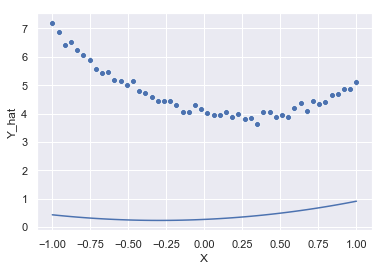

In [5]:
plot(X, Y, Y_hat)

In [6]:
def learn(X, Y, theta, alpha=1e-1, epochs=100):
    for e in range(epochs):
        Y_hat = theta[0]*(X**2) + theta[1]*X + theta[2]
        nabla_theta_y_hat = np.array([
            X**2,
            X,
            np.ones(N)
        ])
        nabla_theta_L = np.mean(2*(Y_hat - Y)*nabla_theta_y_hat, axis=1)
        
        theta = theta - alpha*nabla_theta_L
    return theta

In [7]:
learned_theta = learn(X, Y, theta)
Y_hat = learned_theta[0]*X**2 + learned_theta[1]*X + learned_theta[2]

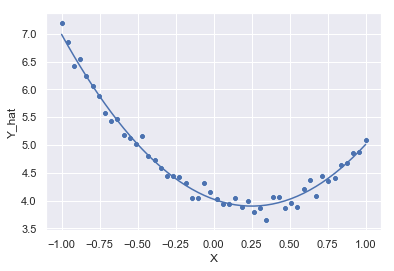

In [8]:
plot(X, Y, Y_hat)

***
### Tensorflow and Autodifferentiation

It can be extremely cumbersome to manually compute the derivative of our functions. It becomes much more complex when our functions are highly composed, where we combine the results of many intermediate calculations to produce our result. Instead, we can rely on libraries that provide **autodifferentiation**. There are many approaches to autodifferentiation, with the notion of a 'gradient tape' being used in [`tensorflow 2`](https://www.tensorflow.org/alpha) and [`pytorch`](https://pytorch.org/). Most guides, resources and open-source implementations that you will find today are built using `tensorflow`, a python library that allows us to define complex **computation graphs** with built-in differentiation. Tensorflow is preferred for many reasons (though the gap may be closing), but using computation graphs can feel weird to a new user.

Tensorflow has [extensive documentation](https://www.tensorflow.org/guide/low_level_intro) that I suggest you spend some time reading, since my goal is not to reproduce the tensorflow guide here. I assume you have a basic understanding of how tensorflow works.

Let us first demonstrate the above regression problem using tensorflow before moving into more complex territory.

In [9]:
N = 50
a, b, c = 2, -1, 4
X = np.linspace(-1, 1, N)
Y = a*X**2 + b*X + c + np.random.randn(N)*0.1

In [10]:
X_ph = tf.placeholder(shape=(50,), dtype=tf.float32) # a placeholder for values, that we will later feed X into
theta = tf.get_variable("theta", initializer=tf.random_normal(shape=(3,))) # our parameters
Y_hat = theta[0]*(X_ph**2) + theta[1]*X_ph + theta[2] # our prediction

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
sess = tf.Session() # used to give tensors in the computation graph values
sess.run(tf.global_variables_initializer()) # initialize defined ops and variables

Y_hat_run = sess.run(Y_hat, 
                    feed_dict = {
                        X_ph: X
                    }) # get initial predictions

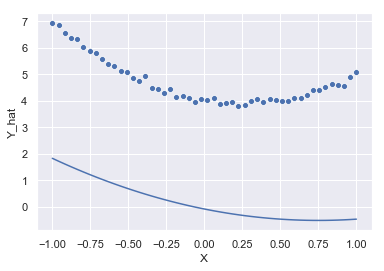

In [12]:
plot(X, Y, Y_hat_run)

In [13]:
L_theta = tf.reduce_mean((Y - Y_hat)**2) # same loss as before
alpha = 1e-1 # learning rate
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(L_theta) # autodifferentiation!

In [14]:
epochs = 100
for e in range(epochs):
    sess.run(optimizer, 
            feed_dict = {
                X_ph:X
            })

In [15]:
Y_hat_run = sess.run(Y_hat, 
                    feed_dict = {
                        X_ph: X
                    })

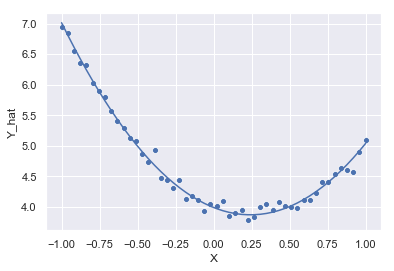

In [16]:
plot(X, Y, Y_hat_run)